In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from import_dataset import import_dataset, import_UKB_subs, dataset_to_data
from nilearn.input_data import NiftiLabelsMasker
import matplotlib
from brainstat.context.meta_analysis import meta_analytic_decoder
from brainstat.datasets import fetch_yeo_networks_metadata
from brainstat.datasets import fetch_parcellation
from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface
from wordcloud import WordCloud
from nilearn import datasets
from nilearn import plotting
from math import pi
from nilearn.image import math_img
from Brainplot.utilities import create_cereb_nii
from nilearn.image import resample_img
from scipy.stats import pearsonr

In [11]:
def my_radar_plot(data=None, title="", axis_range=None, label=None,
                  color=(0, 0, 0), color_fill=(1, 1, 1)):
    # Create dataframe
    class_mean = pd.DataFrame(data=data.T, columns=label)
    # Number of variable
    categories = list(class_mean)
    N = len(categories)
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = class_mean.loc[0].values.flatten().tolist()
    values += values[:1]
    # Angle? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111, polar=True)
    ax.spines["polar"].set_visible(False)
    # Draw one axe per variable + add labels labels yet
    if label is None:
        label = list(class_mean)
    plt.xticks(angles[:-1], label, color="black", size=24)
    ax.xaxis.get_majorticklabels()[0].set_horizontalalignment("left")
    ax.xaxis.get_majorticklabels()[2].set_verticalalignment("bottom")
    ax.xaxis.get_majorticklabels()[3].set_verticalalignment("top")
    # Draw ylabels
    ax.set_rlabel_position(0)
    if axis_range is None:
        axis_range = (np.min(values), np.max(values))
    inc = (axis_range[1] - axis_range[0]) / 4
    newinc = [
        axis_range[0] + inc,
        axis_range[0] + (inc * 2),
        axis_range[0] + (inc * 3),
        axis_range[0],
    ]
    plt.yticks(
        newinc, [str("{:.2f}".format(elem)) for elem in newinc],
        color="black", size=20
    )
    plt.ylim(axis_range)
    # add title
    if title:
        plt.title(title)
    # Plot data
    # ax.xaxis.grid(False)
    ax.plot(angles, values, linewidth=1, linestyle="solid", color=color)
    ax.fill(angles, values, color=color_fill, alpha=0.6)

In [12]:
def my_cbar_plot(data=None, title="", axis_range=None, label=None, color=None):
    # Create dataframe
    class_mean = pd.DataFrame(data=data.T, columns=label)
    # Number of variable
    categories = list(class_mean)
    N = len(categories)
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values = class_mean.loc[0].values.flatten().tolist()
    # values += values[:1]
    # Angle? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    # angles += angles[:1]
    # Initialise the spider plot
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111, polar=True)
    ax.spines["polar"].set_visible(False)
    # Draw one axe per variable + add labels labels yet
    if label is None:
        label = list(class_mean)
    plt.xticks(angles, label, color="black", size=24)
    ax.xaxis.get_majorticklabels()[0].set_horizontalalignment("left")
    ax.xaxis.get_majorticklabels()[2].set_verticalalignment("bottom")
    ax.xaxis.get_majorticklabels()[3].set_verticalalignment("top")
    # Draw ylabels
    ax.set_rlabel_position(0)
    if axis_range is None:
        axis_range = (np.min(values), np.max(values))
    inc = (axis_range[1] - axis_range[0]) / 4
    newinc = [
        axis_range[0] + inc,
        axis_range[0] + (inc * 2),
        axis_range[0] + (inc * 3),
        0,
    ]
    plt.yticks(
        newinc, [str("{:.2f}".format(elem)) for elem in newinc],
        color="black", size=16
    )
    plt.ylim(axis_range)
    if title:
        plt.title(title)
    # Plot data
    bar_color = []
    for i in range(len(label)):
        if values[i] < 0:
            bar_color.append(color[0])
        elif values[i] > 0:
            bar_color.append(color[1])
    # ax.xaxis.grid(True, zorder=1)
    ax.bar(angles, np.abs(values), color=bar_color, alpha=1,
           width=0.45, linewidth=1, edgecolor='k',)
    # plt.set_yticklabels = g.get_xticklabels
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='black', linestyle='dashed')
    # ax.set_axisbelow(True)

Load data

In [6]:
# Load data with regional volumes
df = pd.read_csv('data.csv')
# Print summary
df.iloc[:, 4:].head()

,site_num,CNV,genetic_stat2,age_spm,sex,volume,Front_Pole,Insula,Sup_Front_Gyr,Mid_Front_Gyr,...,I-IV_Cerebellum,V_Cerebellum,VI_Cerebellum,Crus_I_Cerebellum,Crus_II_Cerebellum,VIIb_Cerebellum,VIIIa_Cerebellum,VIIIb_Cerebellum,IX_Cerebellum,X_Cerebellum
570,6.0,15q11.2,deletion,55.0,0.0,587914.0,-0.074164,0.019909,0.001225,0.114149,...,-0.146308,-0.053500,0.016681,0.020838,0.046743,-0.067465,-0.027757,0.045679,-0.104263,0.076513
571,6.0,15q11.2,deletion,48.0,0.0,592574.0,-0.184549,0.030302,0.159501,0.230422,...,0.007876,0.100267,0.021185,0.047022,0.093325,-0.146724,0.019252,-0.100824,-0.082475,-0.039452
572,6.0,15q11.2,deletion,66.0,1.0,611745.0,-0.144978,0.122321,0.275197,0.156425,...,-0.125297,0.013399,0.095192,-0.103760,0.159400,0.082095,0.079173,0.462184,-0.148444,0.159370
573,7.0,15q11.2,deletion,44.0,1.0,627202.0,-0.037130,0.056873,0.122030,0.133258,...,-0.139433,0.006227,-0.042850,0.082768,-0.008729,-0.040657,0.112364,0.180582,-0.065167,0.395848
574,6.0,15q11.2,deletion,60.0,1.0,602985.0,-0.073699,0.026477,0.296261,0.252428,...,-0.283510,-0.072724,0.042752,-0.047456,-0.044656,-0.008032,0.014380,0.071450,-0.052110,-0.029071


Extract regional volumes

In [8]:
# Dataframe with only CNVs
df_mutsubs = df[df.CNV != "Control"]
df_controls = df[df.CNV == "Control"]

scaler = StandardScaler()

# Arrays with brain volumes
X_full = np.array(df.iloc[:, 10:])
X_ctrl = X_full[df.CNV == "Control"]
X_mut = X_full[df.CNV != "Control"]
X_full_ss = scaler.fit_transform(X_full)
X_ctrl_ss = scaler.fit_transform(X_ctrl)
X_mut_ss = scaler.transform(X_mut)

Initialize plotting

In [14]:
plt.rcParams.update({"font.family": "Helvetica Neue"})
matplotlib.rcParams['svg.fonttype'] = 'none'

colors_cat = sns.color_palette("tab20", n_colors=len(category_names))
colors_cat.reverse()
colors_div = sns.color_palette("RdBu_r", n_colors=100)
color = ['#0066B0', '#E8555F']
colors_two = []
for c in color:
    colors_two.append(matplotlib.colors.to_rgb(c))
colors_seq = sns.color_palette("Blues", n_colors=100)

tmp = ['#4FC4CB', '#AF71B0']
colors_two2 = []
for c in tmp:
    colors_two2.append(matplotlib.colors.to_rgb(c))

Classification targets

In [15]:
category_names = ["1q21.1del", "1q21.1dup", "15q11.2del", "15q11.2dup",
                  "16p11.2del", "16p11.2dup", "22q11.2del", "22q11.2dup"]

target_mut = df_mutsubs.CNV.map({"1q21.1": 0, "16p11.2": 1, "22q11.2": 2})
y_mut = df_mutsubs.genetic_stat2.map({"deletion": 0, "duplication": 1})

y = np.array(y_mut + (target_mut * 2))

Load asymmetry patterns

In [17]:
n_boot = 1000  # nb of bstraps

# Load outputs
tmp = np.load('asymmetry_patttern.npz', allow_pickle=True)
all_models = tmp['all_models']
all_models_avg = tmp['all_models_avg']


/Users/jakubkopal/anaconda3/envs/CNV_asym/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearDiscriminantAnalysis from version 1.1.3 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Brain maskers

In [18]:
harvard_oxford_cor = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr0-1mm',
                                                         symmetric_split=False)
harvard_oxford_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr0-1mm',
                                                         symmetric_split=False)
cortical_region = np.concatenate((np.ones(48, dtype=bool),
                                  np.zeros(17, dtype=bool)))
subcortical_region = np.concatenate((np.zeros(48, dtype=bool),
                                     np.ones(7, dtype=bool),
                                     np.zeros(10, dtype=bool)))
cereb_region = np.concatenate((np.zeros(55, dtype=bool),
                               np.ones(10, dtype=bool)))
cereb_names = rois_hem[cereb_region]
cereb_names[3] = 'CrusI_Cerebellum'
cereb_names[4] = 'CrusII_Cerebellum'
left_cereb = ['Left_' + reg for reg in cereb_names]
right_cereb = ['Right_' + reg for reg in cereb_names]
cereb_names = np.concatenate((left_cereb, right_cereb))
subcort_oder = [5, 1, 4, 3, 2, 0, 6]
harvard_oxford_cor_rois = np.array(harvard_oxford_cor.labels, dtype=str)
harvard_oxford_sub_rois = np.array(harvard_oxford_sub.labels, dtype=str)
masker_cor = NiftiLabelsMasker(labels_img=harvard_oxford_cor.maps,
                               standardize=False, memory='nilearn_cache')
masker_cor.fit()
masker_sub = NiftiLabelsMasker(labels_img=harvard_oxford_sub.maps,
                               standardize=False, memory='nilearn_cache')
masker_sub.fit()

NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x1425e2aa0>,
                  memory='nilearn_cache')

Boostrap significance testing

In [19]:
mask_list = []
for i, cat in enumerate(category_names):
    tmp = all_models[i]
    coeff_boot = np.zeros((X_full.shape[1], n_boot))
    for j in range(n_boot):
        coeff_boot[:, j] = tmp[j].coef_
    boot_mean = np.mean(coeff_boot, axis=1)
    boot_ptile_low = np.percentile(coeff_boot, 2.5, axis=1)
    boot_ptile_high = np.percentile(coeff_boot, 97.5, axis=1)
    boot_ptile = (np.sign(boot_ptile_low) == np.sign(boot_ptile_high)) \
        * boot_mean
    mask = np.abs(boot_ptile) > 0
    mask_list.append(mask)

Neurosynth analysis

FOUND (662 voxels) Left_I_IV
FOUND (708 voxels) Left_V
FOUND (1609 voxels) Left_VI
FOUND (2611 voxels) Left_CrusI
FOUND (2010 voxels) Left_CrusII
FOUND (740 voxels) Left_VIIb
FOUND (846 voxels) Left_VIIIa
FOUND (712 voxels) Left_VIIIb
FOUND (658 voxels) Left_IX
FOUND (121 voxels) Left_X
FOUND (701 voxels) Right_I_IV
FOUND (698 voxels) Right_V
FOUND (1468 voxels) Right_VI
FOUND (2630 voxels) Right_CrusI
FOUND (1910 voxels) Right_CrusII
FOUND (834 voxels) Right_VIIb
FOUND (836 voxels) Right_VIIIa
FOUND (697 voxels) Right_VIIIb
FOUND (685 voxels) Right_IX
FOUND (125 voxels) Right_X
FOUND 20 tract(s) for Regular


2024-01-16 17:22:04,120 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-01-16 17:22:04,176 - brainstat - INFO - Running correlations with all Neurosynth features.
{'primary auditory': 0.45129880793618754, 'heschl gyrus': 0.44939305306983623, 'planum': 0.44763220159915373, 'planum temporale': 0.44464092

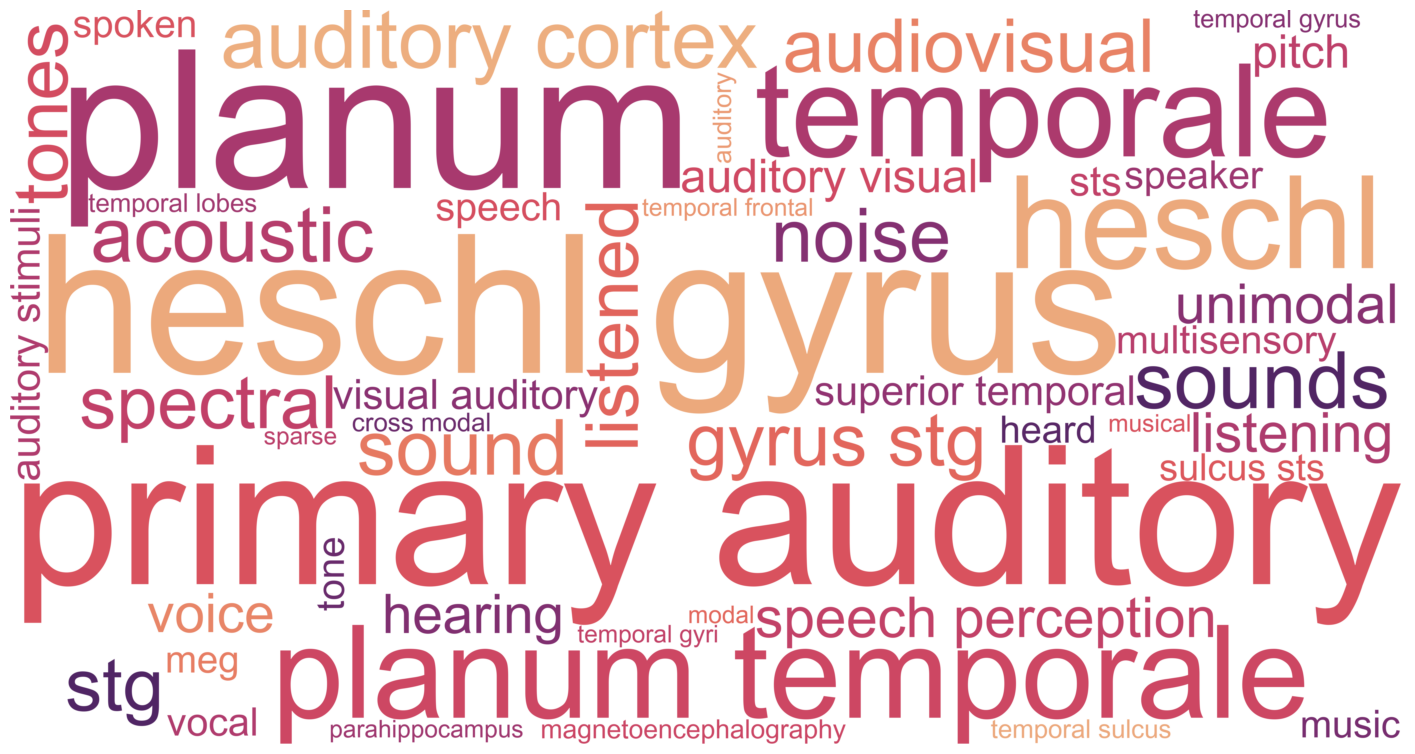

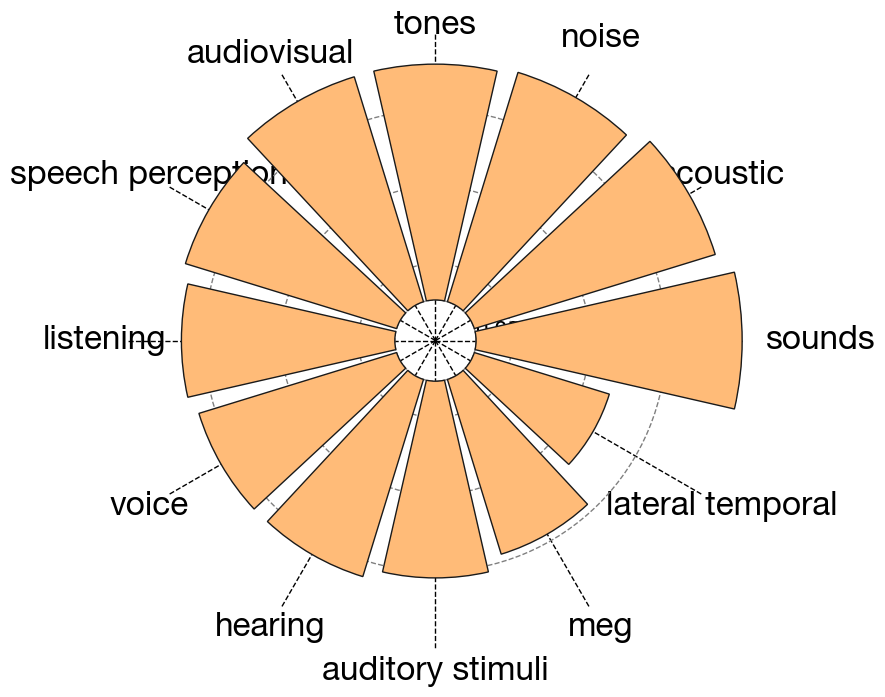

/var/folders/p2/p07_4q2s2vq2gnrl1hh3yvfw0000gn/T/ipykernel_11287/1765678427.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45,


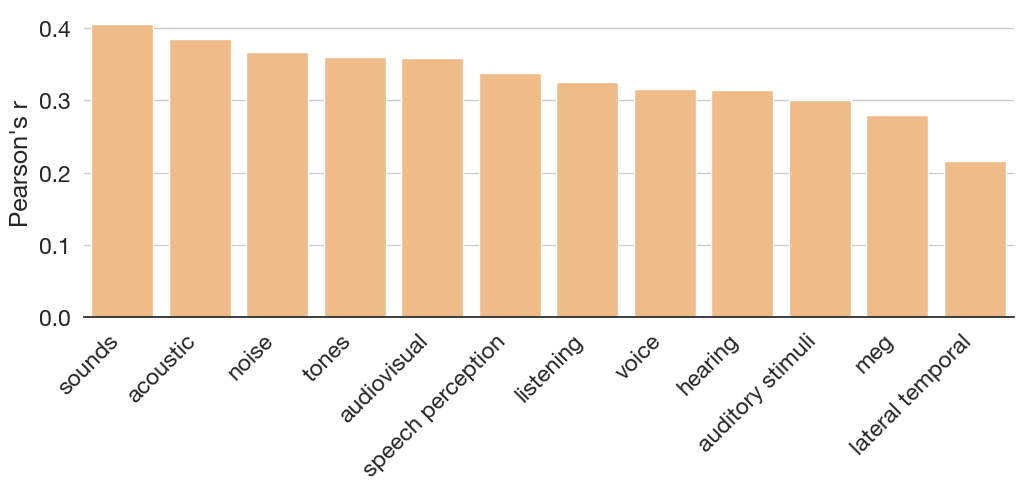

In [22]:
wc = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf',
               background_color="white", width=2*3800, height=2*2000,
               max_words=50, random_state=1, colormap='flare')

for i, cat in enumerate(category_names):
    i = 4
    cat = category_names[i]

    # Project LDA coefficients on the brain
    data = (all_models_avg[i, :])
    data = np.abs(scale.fit_transform(data.reshape(-1, 1)))

    data_sub = np.concatenate((np.zeros(3), data[subcortical_region, 0]))
    data_sub = np.concatenate((data_sub, np.array([0]), data_sub))
    nifti_sub = masker_sub.inverse_transform(data_sub)

    data_cor = data[cortical_region, 0]
    nifti_cor = masker_cor.inverse_transform(data_cor)

    data_cer = np.tile(data[cereb_region, 0], 2)
    nifti_cereb = create_cereb_nii(pd.Series(data_cer, index=cereb_names),
                                   expt_type_abbr='Regular')

    # Upsample
    affine, shape = nifti_cor.affine, nifti_cor.shape
    nifti_cereb2 = resample_img(nifti_cereb, affine, shape[:3])

    result_img = math_img("img1 + img2",
                          img1=nifti_cor, img2=nifti_cereb2)

    fsa = fetch_surf_fsaverage(mesh="fsaverage5")
    texture_right = (surface.vol_to_surf(result_img, fsa.pial_right))
    texture_left = (surface.vol_to_surf(result_img, fsa.pial_left))

    # and then do a similar decoding on the z_val vectors
    my_map = np.concatenate([texture_left, texture_right])

    # run the meta-analysis
    meta_analysis = meta_analytic_decoder("fsaverage5", my_map)

    # wordcloud of the meta-analysis
    df = meta_analysis.reset_index(drop=False)
    df['abs R'] = np.abs(df["Pearson's r"].values)
    df = df.sort_values(by=['abs R'], ascending=False)
    wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
    sns.set_theme(style="white", palette="colorblind", font_scale=2.2,
                  font='Helvetica Neue', rc={"axes.spines.right": False,
                                             "axes.spines.top": False,
                                             "axes.spines.left": False})
    plt.figure(figsize=[18, 10])
    plt.imshow(wc, interpolation='bilinear',)
    fig = plt.gcf()
    plt.axis("off")
    print(meta_analysis.to_dict()["Pearson's r"])
    plt.show()

    # radial plot of functional topics
    numFeat = 12
    data = meta_analysis.to_numpy()[functional_labels_pos[i]][:numFeat]
    label = meta_analysis.index[functional_labels_pos[i]][:numFeat]
    
    my_cbar_plot(np.abs(data), label=label,
                    axis_range=(-0.062, np.max(np.abs(data)+0.002)), # 22q
                 color=np.array([colors_cat[i], colors_cat[i]]))
    fig = plt.gcf()
    plt.show()

    # radial plot of functional topics
    numFeat = 12
    data = meta_analysis.to_numpy()[functional_labels_pos[i]][:numFeat]
    label = meta_analysis.index[functional_labels_pos[i]][:numFeat]
    d = pd.DataFrame({'term': label, 'r': np.abs(data[:, 0])})

    break

Compare associations between CNVs

In [23]:
neuro_cnv = []
for i in np.array([4, 6]):
    cat = category_names[i]
    data = (all_models_avg[i, :])
    data = np.abs(scale.fit_transform(data.reshape(-1, 1)))

    data_sub = np.concatenate((np.zeros(3), data[subcortical_region, 0]))
    data_sub = np.concatenate((data_sub, np.array([0]), data_sub))
    nifti_sub = masker_sub.inverse_transform(data_sub)

    data_cor = data[cortical_region, 0]
    nifti_cor = masker_cor.inverse_transform(data_cor)

    data_cer = np.tile(data[cereb_region, 0], 2)
    nifti_cereb = create_cereb_nii(pd.Series(data_cer, index=cereb_names),
                                   expt_type_abbr='Regular')

    # Upsample
    affine, shape = nifti_cor.affine, nifti_cor.shape
    nifti_cereb2 = resample_img(nifti_cereb, affine, shape[:3])

    result_img = math_img("img1 + img2 + img3",
                          img1=nifti_cor, img2=nifti_sub, img3=nifti_cereb2)

    fsa = fetch_surf_fsaverage(mesh="fsaverage5")
    texture_right = (surface.vol_to_surf(result_img, fsa.pial_right))
    texture_left = (surface.vol_to_surf(result_img, fsa.pial_left))

    # and then do a similar decoding on the z_val vectors
    my_map = np.concatenate([texture_left, texture_right])
    meta_analysis = meta_analytic_decoder("fsaverage5", my_map)
    neuro_cnv.append(meta_analysis)

FOUND (662 voxels) Left_I_IV
FOUND (708 voxels) Left_V
FOUND (1609 voxels) Left_VI
FOUND (2611 voxels) Left_CrusI
FOUND (2010 voxels) Left_CrusII
FOUND (740 voxels) Left_VIIb
FOUND (846 voxels) Left_VIIIa
FOUND (712 voxels) Left_VIIIb
FOUND (658 voxels) Left_IX
FOUND (121 voxels) Left_X
FOUND (701 voxels) Right_I_IV
FOUND (698 voxels) Right_V
FOUND (1468 voxels) Right_VI
FOUND (2630 voxels) Right_CrusI
FOUND (1910 voxels) Right_CrusII
FOUND (834 voxels) Right_VIIb
FOUND (836 voxels) Right_VIIIa
FOUND (697 voxels) Right_VIIIb
FOUND (685 voxels) Right_IX
FOUND (125 voxels) Right_X
FOUND 20 tract(s) for Regular


2024-01-16 17:24:29,453 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-01-16 17:24:29,509 - brainstat - INFO - Running correlations with all Neurosynth features.
FOUND (662 voxels) Left_I_IV
FOUND (708 voxels) Left_V
FOUND (1609 voxels) Left_VI
FOUND (2611 voxels) Left_CrusI
FOUND (2010 voxels) Left_C

Plot comparison

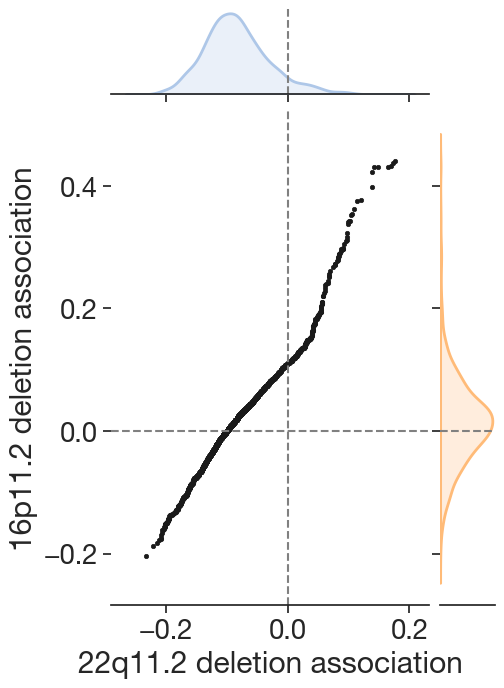

Corr: 0.9889413705389286


In [24]:
d = pd.DataFrame({"16p11.2 deletion association": neuro_cnv[0].values[:, 0],
                  '22q11.2 deletion association': neuro_cnv[1].values[:, 0]})
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.8,
              font='Helvetica Neue', rc={"axes.spines.right": False,
                                         "axes.spines.top": False,
                                         "axes.spines.left": False})
g = sns.JointGrid(height=7)
g.fig.set_figwidth(4.6)
g.fig.set_figheight(7)
x, y = d["22q11.2 deletion association"], d["16p11.2 deletion association"]
sns.scatterplot(x=x, y=y, fc='k', ec='k', linewidth=0.5, s=10, ax=g.ax_joint)
g.refline(x=0, y=0)
sns.kdeplot(x=x, fill=True, linewidth=2, color=colors_cat[6], ax=g.ax_marg_x)
sns.kdeplot(y=y, fill=True, linewidth=2, color=colors_cat[4], ax=g.ax_marg_y)
sns.despine(left=True)
plt.show()

print('Corr: ' + str(pearsonr(d.values[:, 0], d.values[:, 1])[0]))